**Практика 5: Атака с ограниченной памятью (PGD - Projected Gradient Descent)**

Белов Владимир Станиславович ББМО-01-23

**Цель задания:**
Изучить одну из наиболее мощных атак на модели ИИ — атаку Carlini-Wagner (CW). Задача — научиться использовать CW для создания противоречивых примеров и исследовать влияние этой атаки на обученные модели

**Задачи:**
 1. Загрузить ранее обученную модель на датасете MNIST.
 2. Изучить теоретические основы атаки Carlini-Wagner.
 3. Реализовать атаку CW с помощью фреймворка Foolbox.
 4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных
 данных.

**Шаг 1:** Загрузка обученной модели и данных MNIST из предыдущей практики для дальнейшего анализа.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели
model = tf.keras.models.load_model('/content/sample_data/mnist_model.h5')
# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Точность на обычных изображениях: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9751 - loss: 0.0808
Точность на обычных изображениях: 0.9779999852180481


**Шаг 2:** Реализация атаки PGD с использованием Foolbox.

Установка Foolbox:

In [2]:
!pip install foolbox


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.4 MB/s eta 0:00:00


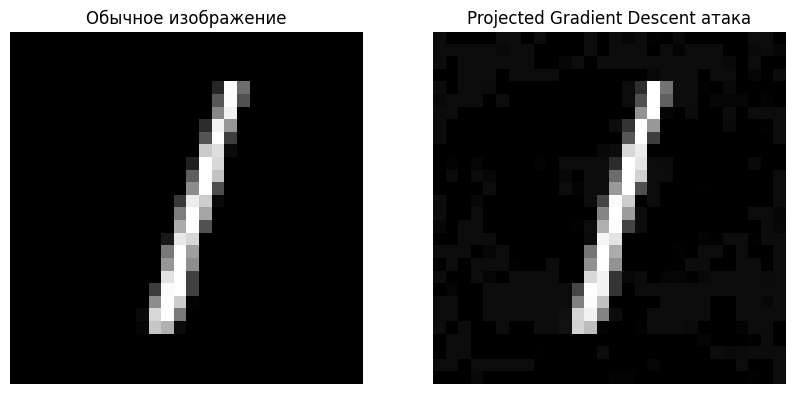

In [9]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Создание атаки DeepFool
attack = fb.attacks.LinfPGD()

# Выбор изображения для атаки (например, первое изображение из тестового набора)
image = tf.convert_to_tensor(test_images[2], dtype=tf.float32)[None, ...]
label = tf.convert_to_tensor(np.argmax(test_labels[0]), dtype=tf.int64)

# Выполнение атаки
adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.05)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Обычное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Projected Gradient Descent атака")
plt.imshow(adversarial_image[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

**Шаг 4**: Оценка модели на противоречивых примерах.

Теперь мы проверим, как сильно атака PGD влияет на точность модели. Мы создадим набор противоречивых примеров и оценим производительность модели на этих данных.

In [8]:
# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []

# Обработка изображений
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.05)
    adversarial_images.append(advs)

# Конвертация в массив
adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Точность противоречивых примеров (PGD): {adversarial_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4387 - loss: 2.0095
Точность противоречивых примеров (PGD): 0.4934000074863434


**Вывод**

Точность модели на противоречивых примерах, созданных с помощью атаки Projected Gradient Descent, снизилась примерно в два раза, с 97,8% сравнению с чистыми данными до ~49,3%. Это демонстрирует существенную уязвимость модели перед PGD атаками.